In [70]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as pg
from sklearn import utils
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')

pio.templates.default = "plotly_dark"

In [71]:
def model_metrics(a_train, p_train, a_test, p_test):
    tdf = pd.DataFrame(index=['Score'])

    tdf['Training Accuracy'] = metrics.accuracy_score(a_train, p_train)
    tdf['Testing Accuracy'] = metrics.accuracy_score(a_test, p_test)
    tdf['Recall'] = metrics.recall_score(a_test, p_test)
    tdf['Precision'] = metrics.precision_score(a_test, p_test)
    tdf['F1'] = metrics.f1_score(a_test, p_test)
    tdf['ROC AUC'] = metrics.roc_auc_score(a_test, p_test)
    
    return tdf


In [72]:
df = pd.read_csv('ibm_telco_customer_churn.csv')
# Using churn score is cheating, as it is already the result of predictions from this dataset

target = 'Churn Value'
cols_to_drop = ['Churn Score', 'Churn Reason', 'Churn Label', 'Latitude', 'Longitude', 'Zip Code', 'Lat Long', 'CustomerID', 'Count', 'Country', 'State', 'Gender', 'City']


df.drop(columns=cols_to_drop, inplace=True)

# Total Charges is an object for some reason.
df['Total Charges'].replace(' ', 0, inplace=True)
df['Total Charges'] = df['Total Charges'].astype(float)


binary_features = [c for c in df.columns if len(df[c].unique()) == 2 and df[c].dtype==object]
multiopt_features = [c for c in df.columns if df[c].dtype==object and c not in binary_features]

df[binary_features] = df[binary_features].apply(lambda g: g.map({"Yes": 1, "No": 0}))

# using pd.get_dummies because it keeps the options as separate features for interpretability
nf = pd.get_dummies(df, columns=multiopt_features).dropna()

# upsampling to deal with bad precision due to the churn class being smaller than non-churn.

churned = nf[nf[target] == 1]
not_churned = nf[nf[target] == 0]

upsampled = utils.resample(churned, replace=True, n_samples=len(not_churned), random_state=1)

rf = pd.concat([upsampled, not_churned])

x = rf.drop(columns=[target])
y = rf[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)



categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1


,Training Accuracy,Testing Accuracy,Recall,Precision,F1,ROC AUC
Score,0.98647,0.884058,0.938036,0.849008,0.891304,0.883318


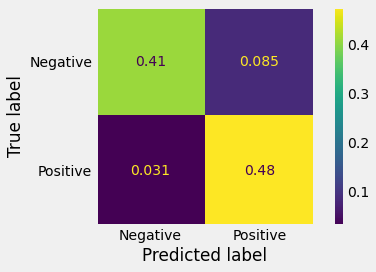

In [73]:
bin_feat_idx = [x.columns.get_loc(col) for col in x.columns if col in binary_features]
mopt_feat_idx = [x.columns.get_loc(col) for col in x.columns if x[col].dtype=='uint8']

cat_feat_idx = bin_feat_idx + mopt_feat_idx

clf_kw = dict(learning_rate=0.01, categorical_feature=cat_feat_idx, importance_type='gain', n_estimators=2500, min_gain_to_split=0.1, num_leaves=100, min_data_in_leaf=60)

model = lgb.LGBMClassifier(**clf_kw)

model.fit(x_train, y_train)

p_train = model.predict(x_train)

p_test = model.predict(x_test)

mdf = model_metrics(y_train, p_train, y_test, p_test)
 
display(mdf)

kw_opts = dict(display_labels=['Negative', 'Positive'], normalize='all')
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_test, p_test, **kw_opts) 
cm.figure_.tight_layout()
cm.ax_.grid(False)
plt.show()

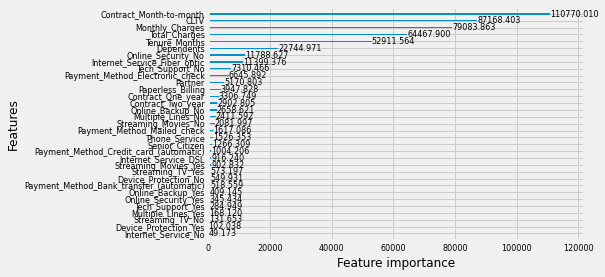

In [74]:
plt.rcParams['axes.labelsize'] = 12

plt.rcParams['font.size'] = 8

lgb.plot_importance(model)
plt.title("")
plt.show()

In [75]:
# explainer = shap.Explainer(model) 
# sv = explainer(x_train)

# exp = shap.Explanation(sv[:, :, 1], sv.base_values[:, 1], x_train, feature_names=x_train.columns)

# shap.summary_plot(exp)